Устанавливаем и загружаем необходимые библиотеки

In [ ]:
!pip install torchmetrics
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import scipy as sc
import nltk
import re
import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.utils import compute_sample_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from wordcloud import WordCloud, STOPWORDS
import spacy
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics import F1Score
from torch.nn.utils.rnn import pad_sequence
import spacy
from nltk.tokenize import word_tokenize
from spacy.lang.ru.examples import sentences

%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


 Вспомогательные функции

In [ ]:
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus


def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus


def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                          stopwords=STOPWORDS,
                          width=3000,
                          height=2500,
                          max_words=200,
                          random_state=42).generate(str_corpus(corpus))
    return wordCloud

def lemmatize_and_clean_text_eng(text):
    # Очищаем текст от пунктуации и цифр
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip().lower()  # Приводим текст к нижнему регистру
    tokens = word_tokenize(text)


    # Лемматизация каждого слова с исключением стоп-слов
    lemmas = [wordnet_lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_set]

    return ' '.join(lemmas)


def lemmatize_and_clean_text_rus(text):
    text = re.sub(r'[^\w\s]', ' ', text)  # Удаляем пунктуацию
    text = re.sub(r'\d', ' ', text)  # Удаляем цифры
    text = re.sub(r'[A-Za-z]', ' ', text)  # Удаляем латинские буквы
    text = re.sub(r'\s+', ' ', text)  # Заменяем один или более пробелов на один пробел
    text = text.strip()  # Убираем пробелы в начале и конце строки

    # Лемматизация с помощью SpaCy и удаление стоп слов
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space and token.text in nlp.vocab]
    return ' '.join(lemmas)


Загружаем данные

In [ ]:
dx1 = pd.read_csv('/content/IRAhandle_tweets_1.csv')
dx2 = pd.read_csv('/content/IRAhandle_tweets_2.csv')
dx3 = pd.read_csv('/content/IRAhandle_tweets_3.csv')
dx4 = pd.read_csv('/content/IRAhandle_tweets_4.csv')


Краткое описание


external_author_id-An author account ID from Twitter

author-The handle sending the tweet

content-The text of the tweet

region-A region classification, as determined by Social Studio

language-The language of the tweet

publish_date-The date and time the tweet was sent

harvested_date-The date and time the tweet was collected by Social Studio

following-The number of accounts the handle was following at the time of the tweet

followers-The number of followers the handle had at the time of the tweet

updates-The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes

post_type-Indicates if the tweet was a retweet or a quote-tweet

account_type-Specific account theme, as coded by Linvill and Warren

retweet-A binary indicator of whether or not the tweet is a retweet

account_category-General account theme, as coded by Linvill and Warren

new_june_2018-A binary indicator of whether the handle was newly listed in June 2018

alt_external_id-Reconstruction of author account ID from Twitter, derived from article_url variable and the first list provided to Congress

tweet_id-Unique id assigned by twitter to each status update, derived from article_url

article_url-Link to original tweet. Now redirects to "Account Suspended" page

tco1_step1-First redirect for the first http(s)://t.co/ link in a tweet, if it exists

tco2_step1-First redirect for the second http(s)://t.co/ link in a tweet, if it exists

tco3_step1-First redirect for the third http(s)://t.co/ link in a tweet, if it exists

In [ ]:
df = pd.concat([dx1, dx2, dx3, dx4])
df

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246789,1662453998,ERRIVVVVERS,$1000+/wk who want easy money? https://t.co/A0...,United States,English,1/31/2017 13:34,1/31/2017 13:34,854,861,3905,...,Left,1,LeftTroll,0,1662453998,826423400646246400,http://twitter.com/1662453998/statuses/8264234...,https://twitter.com/THEREALTYMULA/status/49679...,NaN,NaN
246790,1662453998,ERRIVVVVERS,Thank you Walgreens! #EdgeCases https://t.co/H...,United States,English,1/31/2017 13:35,1/31/2017 13:35,854,861,3906,...,Left,1,LeftTroll,0,1662453998,826423609585438722,http://twitter.com/1662453998/statuses/8264236...,https://twitter.com/scoober/status/82641946154...,NaN,NaN
246791,1662453998,ERRIVVVVERS,Now Playing: Coca Vango - Kash Talk -&gt; http...,United States,English,1/31/2017 15:36,1/31/2017 15:37,854,862,3908,...,Left,1,LeftTroll,0,1662453998,826454193942757376,http://twitter.com/1662453998/statuses/8264541...,http://1063.mobi,NaN,NaN
246792,1662453998,ERRIVVVVERS,"""Everybody wanna know my net worth / Niggaz wa...",United States,English,1/31/2017 15:36,1/31/2017 15:37,854,862,3907,...,Left,1,LeftTroll,0,1662453998,826454150946947073,http://twitter.com/1662453998/statuses/8264541...,NaN,NaN,NaN


Отбросим часть ненужных столбцов

In [ ]:
dff = df.drop(['external_author_id', 'author','tweet_id','alt_external_id','article_url','tco1_step1','tco2_step1','tco3_step1'], axis=1)
dff

,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018
0,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,RightTroll,0
1,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,RightTroll,0
2,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,1,RightTroll,0
3,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,RightTroll,0
4,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,1,RightTroll,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246789,$1000+/wk who want easy money? https://t.co/A0...,United States,English,1/31/2017 13:34,1/31/2017 13:34,854,861,3905,RETWEET,Left,1,LeftTroll,0
246790,Thank you Walgreens! #EdgeCases https://t.co/H...,United States,English,1/31/2017 13:35,1/31/2017 13:35,854,861,3906,RETWEET,Left,1,LeftTroll,0
246791,Now Playing: Coca Vango - Kash Talk -&gt; http...,United States,English,1/31/2017 15:36,1/31/2017 15:37,854,862,3908,RETWEET,Left,1,LeftTroll,0
246792,"""Everybody wanna know my net worth / Niggaz wa...",United States,English,1/31/2017 15:36,1/31/2017 15:37,854,862,3907,RETWEET,Left,1,LeftTroll,0


Посмотрим на целевые классы для классификации

In [ ]:
dff['account_category'].unique()

array(['RightTroll', 'NonEnglish', 'Fearmonger', 'LeftTroll', 'Unknown',
       'HashtagGamer', 'NewsFeed', 'Commercial'], dtype=object)

Количество языков, на котором написаны твитты

In [ ]:
dff['language'].unique()

array(['English', 'Russian', 'Serbian', 'Ukrainian', 'Tagalog (Filipino)',
       'Albanian', 'Italian', 'Romanian', 'Spanish', 'Catalan', 'German',
       'Estonian', 'French', 'Norwegian', 'Vietnamese', 'Dutch', 'Arabic',
       'Uzbek', 'Bulgarian', 'Macedonian', 'Farsi (Persian)', 'Turkish',
       'LANGUAGE UNDEFINED', 'Czech', 'Somali', 'Lithuanian', 'Croatian',
       'Slovak', 'Icelandic', 'Slovenian', 'Japanese', 'Indonesian',
       'Pushto', 'Hungarian', 'Finnish', 'Latvian', 'Portuguese',
       'Danish', 'Swedish', 'Malay', 'Polish', 'Korean', 'Hebrew', 'Urdu',
       'Kurdish', 'Hindi', 'Greek', 'Simplified Chinese', 'Thai',
       'Bengali', 'Traditional Chinese', 'Gujarati'], dtype=object)

Возьмем только русский и английский язык (большинство твиттов)

In [ ]:
d_eng = dff[dff['language']=='English']
d_rus = dff[dff['language']=='Russian']
d_rus

,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018
372,Причина #67 Мутко: «Зенит-Арене» для адаптации...,Unknown,Russian,1/19/2017 13:07,1/19/2017 13:07,6311,6313,1806,NaN,Russian,0,NonEnglish,0
373,Причина #70 Житель Самары умер в очереди в пол...,Unknown,Russian,1/22/2017 12:37,4/5/2017 7:17,1580,6298,1869,NaN,Russian,0,NonEnglish,0
374,Причина #74 Президентский советник предложил о...,Unknown,Russian,1/26/2017 15:39,1/26/2017 15:40,6305,6312,1813,NaN,Russian,0,NonEnglish,0
375,Причина #75 Казаков благословили на защиту инт...,Unknown,Russian,1/27/2017 13:23,1/27/2017 13:23,6304,6311,1814,NaN,Russian,0,NonEnglish,0
376,Причина #77 В Кстово полицейские сломали женщи...,Unknown,Russian,1/29/2017 11:07,1/29/2017 11:30,6306,6308,1816,NaN,Russian,0,NonEnglish,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246165,Десятки тысяч людей участвуют в акции протеста...,United States,Russian,9/6/2015 10:55,9/6/2015 10:55,1846,815,11819,RETWEET,Russian,1,NonEnglish,1
246166,Пушилин: с Пургиным все в порядке http://t.co/...,United States,Russian,9/7/2015 16:32,9/7/2015 16:32,1846,815,11824,RETWEET,Russian,1,NonEnglish,1
246167,Смолов признан лучшим игроком «Краснодара» в а...,United States,Russian,9/7/2015 9:31,9/7/2015 9:31,1846,815,11819,RETWEET,Russian,1,NonEnglish,1
246168,Собачников поджидают в парках http://t.co/ToV...,United States,Russian,9/8/2015 15:34,9/8/2015 15:34,1846,814,11837,RETWEET,Russian,1,NonEnglish,1


Отбрасываем оставшиеся лишнние столбцы

In [ ]:
d_eng = d_eng.drop(['language','region','publish_date','harvested_date','following','followers','updates','post_type','account_type','retweet','new_june_2018'], axis=1)
d_rus = d_rus.drop(['language','region','publish_date','harvested_date','following','followers','updates','post_type','account_type','retweet','new_june_2018'], axis=1)
d_eng

,content,account_category
0,"""We have a sitting Democrat US Senator on tria...",RightTroll
1,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll
3,JUST IN: President Trump dedicates Presidents ...,RightTroll
4,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll
...,...,...
246789,$1000+/wk who want easy money? https://t.co/A0...,LeftTroll
246790,Thank you Walgreens! #EdgeCases https://t.co/H...,LeftTroll
246791,Now Playing: Coca Vango - Kash Talk -&gt; http...,LeftTroll
246792,"""Everybody wanna know my net worth / Niggaz wa...",LeftTroll


Приводим к нижнему регистру и чистим английскую часть датасета

In [ ]:
stopwords_set = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
d_eng['content'] = d_eng['content'].apply(lemmatize_and_clean_text_eng)
d_eng

,content,account_category
0,sitting democrat u senator trial corruption ba...,RightTroll
1,marshawn lynch arrives game anti trump shirt j...,RightTroll
2,daughter fallen navy sailor delivers powerful ...,RightTroll
3,president trump dedicates president cup golf t...,RightTroll
4,respecting national anthem standforouranthem h...,RightTroll
...,...,...
246789,wk want easy money http co q wdwf c,LeftTroll
246790,thank walgreens edgecases http co hndb xu,LeftTroll
246791,playing coca vango kash talk gt http co emx jg...,LeftTroll
246792,everybody wan na know net worth niggaz wake di...,LeftTroll


In [ ]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 69.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Подготавливаемся к лемматизации русского текста

In [ ]:

nlp = spacy.load('ru_core_news_sm')
russian_stopwords = stopwords.words('russian')

In [ ]:
d_rus['content'] = d_rus['content'].apply(lemmatize_and_clean_text_rus)
d_rus

,content,account_category
372,причина мутко зенит арена адаптация чм потребо...,NonEnglish
373,причина житель самара умереть очередь поликлиника,NonEnglish
374,причина президентский советник предложить огра...,NonEnglish
375,причина казак благословили защита интернет про...,NonEnglish
376,причина кстово полицейский сломать женщина лиц...,NonEnglish
...,...,...
246165,десяток тысяча человек участвовать акция проте...,NonEnglish
246166,пушилин пургиным порядок,NonEnglish
246167,смолов признать хороший игрок краснодар август,NonEnglish
246168,собачник поджидать парк,NonEnglish


Посмотрим, какие слова чаще всего фигурировали в ру и анг сегментах твиттера

In [ ]:
corpus = get_corpus(d_eng['content'])


In [ ]:
corpus_ru = get_corpus(d_rus['content'])

In [ ]:
proc = get_wordCloud(corpus)

In [ ]:
proc_ru = get_wordCloud(corpus_ru)

<Axes: >

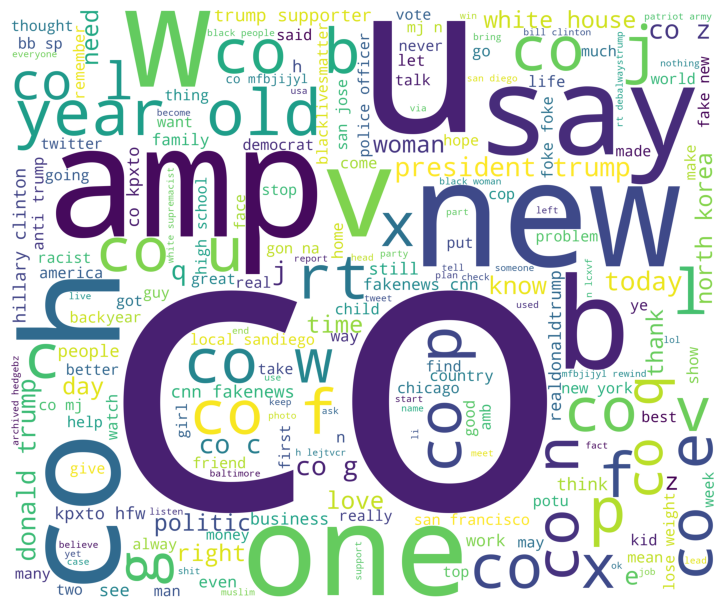

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(proc)
plt.axis('off')
plt.subplot(1,2,1)

<Axes: >

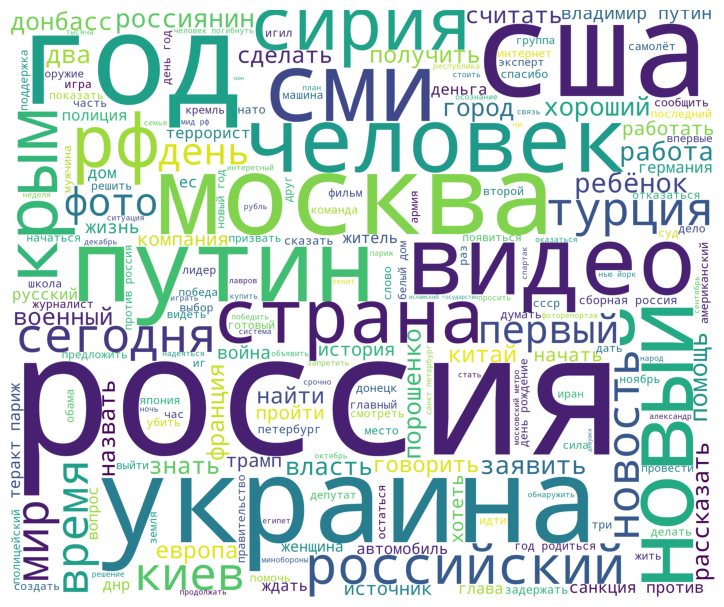

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(proc_ru)
plt.axis('off')
plt.subplot(1,2,1)

Посмотрим на распределение классов

Собираем английский и русский датасет в 1

In [ ]:
twitts = pd.concat([d_eng, d_rus])
twitts

,content,account_category
0,sitting democrat u senator trial corruption ba...,RightTroll
1,marshawn lynch arrives game anti trump shirt j...,RightTroll
2,daughter fallen navy sailor delivers powerful ...,RightTroll
3,president trump dedicates president cup golf t...,RightTroll
4,respecting national anthem standforouranthem h...,RightTroll
...,...,...
246165,десяток тысяча человек участвовать акция проте...,NonEnglish
246166,пушилин пургиным порядок,NonEnglish
246167,смолов признать хороший игрок краснодар август,NonEnglish
246168,собачник поджидать парк,NonEnglish


In [ ]:
twitts.groupby('account_category').size()

account_category
Commercial       12417
Fearmonger        2578
HashtagGamer    122369
LeftTroll       159225
NewsFeed        157407
NonEnglish      133321
RightTroll      330486
Unknown           1497
dtype: int64

In [ ]:
twitts = twitts.reset_index(drop=True)
twitts

,content,account_category
0,sitting democrat u senator trial corruption ba...,RightTroll
1,marshawn lynch arrives game anti trump shirt j...,RightTroll
2,daughter fallen navy sailor delivers powerful ...,RightTroll
3,president trump dedicates president cup golf t...,RightTroll
4,respecting national anthem standforouranthem h...,RightTroll
...,...,...
919295,десяток тысяча человек участвовать акция проте...,NonEnglish
919296,пушилин пургиным порядок,NonEnglish
919297,смолов признать хороший игрок краснодар август,NonEnglish
919298,собачник поджидать парк,NonEnglish


1 Для baseline модели возьмем градиентный бустинг и посмотрим

In [ ]:

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(twitts['content'], twitts['account_category'] , test_size=0.2, random_state=42)

Так как у нас явный дисбаланс классов, посчитаем для каждого класса свой вес

In [ ]:
sample_weights_eng = compute_sample_weight(class_weight='balanced', y=y_test_eng)


In [ ]:
cat_eng = Pipeline([('tfidf', TfidfVectorizer()),('cat',CatBoostClassifier(
    auto_class_weights='Balanced',
    random_state=10,
    task_type='CPU',
))])

In [ ]:
cat_eng.fit(X_train_eng, y_train_eng)

In [ ]:
predicted_cat = cat_eng.predict(X_test_eng)

In [ ]:
print(classification_report(predicted_cat,y_test_eng, sample_weight=sample_weights_eng))

              precision    recall  f1-score   support

  Commercial       0.80      0.94      0.86 19562.29059769874
  Fearmonger       0.69      0.89      0.78 17879.49544820952
HashtagGamer       0.58      0.69      0.63 19424.24808919443
   LeftTroll       0.46      0.44      0.45 24054.747435855494
    NewsFeed       0.85      0.51      0.64 38114.58716508902
  NonEnglish       0.95      0.61      0.75 35788.20687016534
  RightTroll       0.49      0.76      0.60 15005.328454576702
     Unknown       0.33      0.55      0.42 14031.095939198138

    accuracy                           0.65 183859.99999998737
   macro avg       0.65      0.67      0.64 183859.99999998737
weighted avg       0.70      0.65      0.65 183859.99999998737



Мы видим, что бустинг достиг средних результатов, причем обучение проходило на CPU, так как в память видеокарты не влезло

2 Возьмем кастомную обычную нейронную сетку на LSTM

In [ ]:
all_eng = ' '.join(twitts['content']).split()



In [ ]:
# Получаем уникальные слова и сортируем их
unique_words_eng = sorted(set(all_eng))


Преобразуем классы

In [ ]:
labels_eng = twitts['account_category'].values.tolist()


In [ ]:

encoder = LabelEncoder()
labels_eng = encoder.fit_transform(labels_eng)


In [ ]:
# Создаем словарь, где каждому слову соответствует уникальный индекс
word_to_index_eng = {word: index for index, word in enumerate(unique_words_eng, start=1)}


In [ ]:
len(word_to_index_eng)

952553

In [ ]:
#Преобразование текстов в числовые последовательности
def text_to_sequence(text, word_to_index):
    return [word_to_index.get(word, 0) for word in text.split()]  # Используем 0 для неизвестных слов

sequences_eng = [text_to_sequence(text, word_to_index_eng) for text in twitts['content']]


In [ ]:
device = torch.device("cuda")
print(f"Using {device} device")


Using cuda device


In [ ]:
sequences_eng_train, sequences_eng_test, labels_eng_train, labels_eng_test = train_test_split(
    sequences_eng, labels_eng , test_size=0.2, random_state=42)


In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [ ]:
def collate_fn(batch):
    sequences, labels = zip(*batch)
    # Дополняем последовательности в батче до одинаковой длины
    sequences = [torch.tensor(s, dtype=torch.long) for s in sequences]
    labels = torch.tensor(labels, dtype=torch.long)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return sequences_padded, labels

In [ ]:
train_dataset_eng = TextDataset(sequences_eng_train, labels_eng_train)
test_dataset_eng = TextDataset(sequences_eng_test, labels_eng_test)


In [ ]:
train_loader_eng = DataLoader(train_dataset_eng, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader_eng = DataLoader(test_dataset_eng, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM слой
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Batch Normalization для выхода LSTM
        self.batchnorm = nn.BatchNorm1d(hidden_dim)

        # Дропаут после LSTM
        self.dropout = nn.Dropout(dropout_rate)

        # Полносвязные слои
        self.fc1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, sequences):
        embedded = self.embedding(sequences)
        lstm_out, _ = self.lstm(embedded)

        # Применяем BatchNorm и Dropout к последнему скрытому состоянию
        lstm_out = self.batchnorm(lstm_out[:, -1, :])
        lstm_out = self.dropout(lstm_out)

        # Полносвязные слои
        out = torch.relu(self.fc1(lstm_out))
        out = self.dropout(out)  # Дропаут перед последним слоем
        logits = self.fc2(out)

        return logits

In [ ]:
model_en = LSTMModel(vocab_size=953000,  # предполагаемый размер словаря
                  embedding_dim=600,  # размерность эмбеддингов
                  hidden_dim=512,  # размер скрытого слоя LSTM
                  output_dim=8,  # количество классов для задачи классификации
                  dropout_rate=0.5)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_en.parameters())

In [ ]:
torch.cuda.empty_cache()


In [ ]:
f1_score = F1Score(num_classes=8, average='weighted', task='multiclass')
f1_score = f1_score.to(device)

In [ ]:
from tqdm import tqdm
model_en = model_en.to(device)
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_loss_history = []
    for epoch in range(num_epochs):
        f1_score.reset()
        total_loss = 0
        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            total_loss += loss.item()
            f1_score.update(preds, labels)

        avg_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}, Avg. Loss: {avg_loss:.4f}")
        epoch_f1 = f1_score.compute()
        print(f'Epoch {epoch+1}, F1 Score: {epoch_f1.item()}')
    return train_loss_history

train_loss_history = train_model(model_en, train_loader_eng, criterion, optimizer)


Epoch 1/10:   0%|          | 0/22983 [00:00<?, ?it/s]C:\Users\79169\AppData\Local\Temp\ipykernel_35140\517980914.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
Epoch 1/10: 100%|██████████| 22983/22983 [19:09<00:00, 19.99it/s]


Epoch 1, Avg. Loss: 0.5456
Epoch 1, F1 Score: 0.8108866214752197


Epoch 2/10: 100%|██████████| 22983/22983 [19:17<00:00, 19.86it/s]


Epoch 2, Avg. Loss: 0.3891
Epoch 2, F1 Score: 0.8684344291687012


Epoch 3/10: 100%|██████████| 22983/22983 [19:10<00:00, 19.98it/s]


Epoch 3, Avg. Loss: 0.3248
Epoch 3, F1 Score: 0.8912514448165894


Epoch 4/10: 100%|██████████| 22983/22983 [19:04<00:00, 20.08it/s]


Epoch 4, Avg. Loss: 0.2762
Epoch 4, F1 Score: 0.908916711807251


Epoch 5/10: 100%|██████████| 22983/22983 [19:10<00:00, 19.98it/s]


Epoch 5, Avg. Loss: 0.2337
Epoch 5, F1 Score: 0.9252663254737854


Epoch 6/10: 100%|██████████| 22983/22983 [19:11<00:00, 19.96it/s]


Epoch 6, Avg. Loss: 0.2016
Epoch 6, F1 Score: 0.9368200898170471


Epoch 7/10: 100%|██████████| 22983/22983 [19:11<00:00, 19.96it/s]


Epoch 7, Avg. Loss: 0.1777
Epoch 7, F1 Score: 0.9454302787780762


Epoch 8/10: 100%|██████████| 22983/22983 [19:11<00:00, 19.96it/s]


Epoch 8, Avg. Loss: 0.1603
Epoch 8, F1 Score: 0.9512871503829956


Epoch 9/10: 100%|██████████| 22983/22983 [19:11<00:00, 19.97it/s]


Epoch 9, Avg. Loss: 0.1472
Epoch 9, F1 Score: 0.955399751663208


Epoch 10/10: 100%|██████████| 22983/22983 [19:12<00:00, 19.94it/s]

Epoch 10, Avg. Loss: 0.1373
Epoch 10, F1 Score: 0.9588066339492798


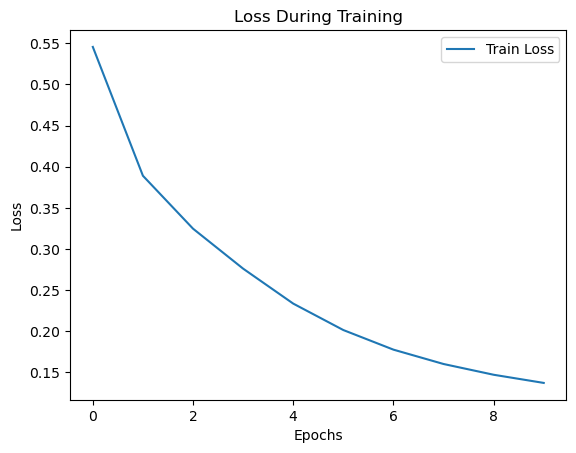

In [ ]:
plt.plot(train_loss_history, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

In [ ]:
def test_model(model, test_loader):
    model.eval()
    f1_score.reset()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            f1_score.update(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    final_f1 = f1_score.compute()
    print(f"Final F1 Score on Test Set: {final_f1.item()}")
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

test_accuracy = test_model(model_en, test_loader_eng)

C:\Users\79169\AppData\Local\Temp\ipykernel_35140\517980914.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Final F1 Score on Test Set: 0.8592132329940796
Test Accuracy: 86.06%


Предобученная модель XLM

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [ ]:
!pip install datasets

In [ ]:
import os
os._exit(00)

In [ ]:
from transformers import XLMRobertaTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import random_split
from datasets import Dataset

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=8)

In [ ]:
twitts['account_category'] = twitts['account_category'].map({'RightTroll': 0, 'NonEnglish': 1,
                                                            'Fearmonger': 2, 'HashtagGamer': 3,
                                                             'LeftTroll': 4, 'NewsFeed': 5,
                                                              'Commercial': 6,'Unknown': 7})
twitts.to_csv('twitts.csv', index=False)
twitts = pd.read_csv('twitts.csv')
twitts

,content,account_category
0,sitting democrat u senator trial corruption ba...,0
1,marshawn lynch arrives game anti trump shirt j...,0
2,daughter fallen navy sailor delivers powerful ...,0
3,president trump dedicates president cup golf t...,0
4,respecting national anthem standforouranthem h...,0
...,...,...
919295,десяток тысяча человек участвовать акция проте...,1
919296,пушилин пургиным порядок,1
919297,смолов признать хороший игрок краснодар август,1
919298,собачник поджидать парк,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(twitts['content'], twitts['account_category'], test_size=0.2, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

In [ ]:
X_train, X_test = X_train.astype(str).tolist(), X_test.astype(str).tolist()

In [ ]:
# Предобработка данных
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)




In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
train_dataset = Dataset(train_encodings, y_train)
test_dataset = Dataset(test_encodings, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
from transformers import AdamW
from transformers import XLMRobertaModel, XLMRobertaConfig
from torch.nn import CrossEntropyLoss

In [ ]:
class CustomXLMRoberta(nn.Module):
    def __init__(self, num_labels):
        super(CustomXLMRoberta, self).__init__()
        config = XLMRobertaConfig.from_pretrained('xlm-roberta-base', num_labels=num_labels)
        self.xlm_roberta = XLMRobertaModel.from_pretrained('xlm-roberta-base', config=config)


        # Добавление слоя нормализации
        self.batch_norm1 = nn.BatchNorm1d(config.hidden_size)

        # Добавление дополнительного полносвязного слоя
        self.linear1 = nn.Linear(config.hidden_size, config.hidden_size // 2)
        self.activation = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm1d(config.hidden_size // 2)

        # Финальный классификатор
        self.classifier = nn.Linear(config.hidden_size // 2, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.xlm_roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state[:, 0, :]

        sequence_output = self.batch_norm1(sequence_output)
        sequence_output = self.linear1(sequence_output)
        sequence_output = self.activation(sequence_output)
        sequence_output = self.batch_norm2(sequence_output)

        logits = self.classifier(sequence_output)
        return logits
# Создаём экземпляр модели с количеством классов для вашей задачи
num_labels = 8
model = CustomXLMRoberta(num_labels=num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fn = CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
f1_score_metric = F1Score(num_classes=8, average='weighted', task='multiclass').to(device)

train_losses = []
f1_scores = []

In [ ]:
optimizer = AdamW(model.parameters(), lr=0.001)
model = model.to(device)
for epoch in range(5):
    model.train()
    total_loss = 0
    f1_score_metric.reset()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        logits = model(**inputs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Обновляем F1 метрику на каждом шаге
        preds = torch.argmax(logits, dim=-1)
        f1_score_metric.update(preds, labels)
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    f1_epoch = f1_score_metric.compute()
    f1_scores.append(f1_epoch.item())  # Преобразуем в число, если метрика возвращает тензор
    f1_score_metric.reset()  # Сбрасываем состояние метрики для следующей эпохи

    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, F1 Score: {f1_epoch:.4f}')

# Построение графиков
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(f1_scores, label='F1 Score', color='orange')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 22983/22983 [2:00:38<00:00,  3.17it/s]


Epoch 1, Loss: 1.5848, F1 Score: 0.2357


100%|██████████| 22983/22983 [2:00:37<00:00,  3.18it/s]


Epoch 2, Loss: 1.5524, F1 Score: 0.2471


100%|██████████| 22983/22983 [2:00:35<00:00,  3.18it/s]


Epoch 3, Loss: 1.5449, F1 Score: 0.2522


 88%|████████▊ | 20267/22983 [1:46:19<14:14,  3.18it/s]

In [ ]:
def test_model(model, test_loader, device):
    # Переключаем модель в режим оценки
    model.eval()

    # Инициализируем метрику F1
    f1_score_metric = F1Score(num_classes=8, average='weighted', task="multiclass").to(device)

    with torch.no_grad():  # В процессе оценки градиенты не нужны
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs)

            # Получаем предсказания
            preds = torch.argmax(outputs, dim=-1)

            # Обновляем метрику F1 на каждом шаге
            f1_score_metric.update(preds, labels)

    # Вычисляем итоговую F1 метрику
    final_f1 = f1_score_metric.compute()

    # Сбрасываем состояние метрики после использования
    f1_score_metric.reset()

    return final_f1.item()


# Выполняем тестирование модели
final_f1_score = test_model(model, test_loader, device)
print(f'Final F1 Score on the test set: {final_f1_score:.4f}')